# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [1]:
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

tfpd = tfp.distributions

In [2]:

from jaxns.special_priors import Bernoulli
from jaxns import Prior, Model

num_predicates = 3


def prior_model():
    p = yield Prior(tfpd.Uniform(jnp.zeros(num_predicates), jnp.ones(num_predicates)), name='p')
    predicates = yield Bernoulli(probs=p, name='predicates')
    p_B = yield Prior(tfpd.Uniform(0.6, 0.9), name='p_B')
    return predicates, p_B


def log_likelihood(predicates, p_B):
    """
    state of knowledge P(a=>(b<=>c)) = p_rule & P(a) = 0.9
    """
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    log_prop = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9)) + jnp.where(b, jnp.log(p_B), jnp.log(1. - p_B))

    return log_prop


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2023-07-04 23:04:12,155]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-07-04 23:04:12,156]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-04 23:04:12,156]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-04 23:04:12,158]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-07-04 23:04:12,158]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-07-04 23:04:12,159]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO[2023-07-04 23:04:13,082]: Sanity check...
INFO[2023-07-04 23:04:13,547]: Sanity check p

In [3]:
from jaxns import ExactNestedSampler, TerminationCondition

# Run the nested sampling
ns = ExactNestedSampler(model=model, num_live_points=200, max_samples=1e4)

term_reason, state = ns(random.PRNGKey(3452345), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = ns.to_results(state, termination_reason=term_reason)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 24405
# samples: 3400
# slices: 0.0
# slices / acceptance: nan
# likelihood evals / sample: 7.2
# likelihood evals / slice: nan
--------
logZ=-1.047 +- 0.042
H=1.6
ESS=742
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.46 +- 0.29 | 0.07 / 0.44 / 0.88 | 0.03 | 0.51
p[1]: 0.59 +- 0.28 | 0.19 / 0.62 / 0.94 | 0.98 | 0.58
p[2]: 0.54 +- 0.28 | 0.12 / 0.55 / 0.93 | 0.02 | 0.63
--------
p_B: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p_B: 0.75 +- 0.09 | 0.629 / 0.74 / 0.874 | 0.855 | 0.9
--------
predicates[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
predicates[0]: 0.4 +- 0.49 | 0.0 / 0.0 / 1.0 | 0.0 | 1.0
predicates[1]: 0.74 +- 0.44 | 0.0 / 1.0 / 1.0 | 1.0 | 1.0
predicates[2]: 0.58 +- 0.49 | 0.0 / 1.0 / 1.0 | 0.0 | 1.0
--------


WARNING[2023-07-04 23:04:22,875]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


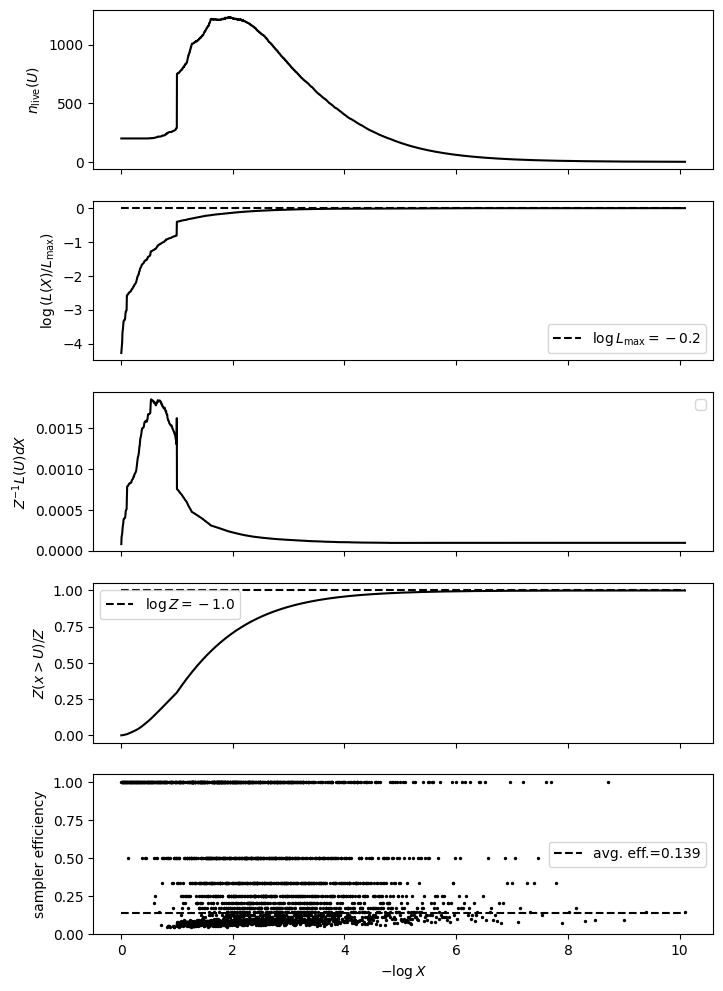

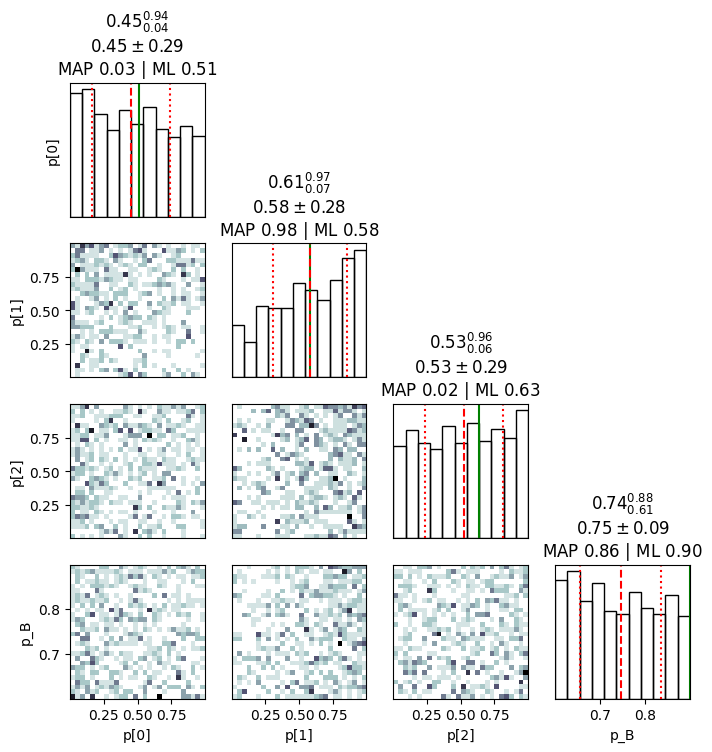

In [4]:
# Inspect results
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results, vars=['p', 'p_B'])